In [ ]:
# # Importing required libraries
# import pandas as pd
# import numpy as np
# from numpy.random import seed
# seed(123)
# import matplotlib.pyplot as plt
# %matplotlib inline
# from datetime import datetime
# import seaborn as sns
# import geopandas as gpd
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split, cross_val_score
# import xgboost as xgb
# from xgboost import plot_importance
# from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
# import time
# from keras import models, layers, optimizers, regularizers
# from keras.utils.vis_utils import model_to_dot
# from IPython.display import SVG
# from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# !pip install xgboost

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\Home Laptop\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('merged_data.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df.duplicated().sum()))

The dataset has 719335 rows and 58 columns.
It contains 764 duplicates.


In [3]:
df.head(1)

,price_id,daily_price,weekly_price,cleaning_fee,security_deposit,availability_id,availability_30,availability_60,availability_90,amenity_id,...,bathrooms,accommodates,beds,room_type,minimum_nights,maximum_nights,latitude,longitude,neighbourhood,zipcode
0,3,55.0,NaN,NaN,NaN,3,18,43,73,3,...,1.0,2,1.0,Private room,1,1125,34.51013,-118.212407,Acton,93510


In [4]:
df.columns

Index(['price_id', 'daily_price', 'weekly_price', 'cleaning_fee',
       'security_deposit', 'availability_id', 'availability_30',
       'availability_60', 'availability_90', 'amenity_id', 'wireless_Internet',
       'air_conditioning', 'pool', 'self_check_in', 'private_entrance',
       'breakfast', 'free_parking_on_premises', 'tv', 'gym', 'hot_tub',
       'indoor_fireplace', 'heating', 'family_kid_friendly', 'washer', 'dryer',
       'hangers', 'iron', 'shampoo', 'hair_dryer', 'high_chair', 'crib',
       'carbon_monoxide_detector', 'smoke_detector',
       'babysitter_recommendations', 'pets_allowed', 'first_aid_kit',
       'host_id', 'host_since', 'host_is_superhost', 'host_response_time',
       'property_id', 'number_of_reviews', 'review_scores_rating', 'comments',
       'neighborhood_id', 'listing_description', 'property_type', 'bedrooms',
       'bathrooms', 'accommodates', 'beds', 'room_type', 'minimum_nights',
       'maximum_nights', 'latitude', 'longitude', 'neighbourho

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

NameError: name 'df_initial' is not defined

In [6]:
df.room_type.value_counts(normalize=True)

Entire home/apt    0.665620
Private room       0.327543
Shared room        0.006837
Name: room_type, dtype: float64

In [7]:
df.property_type.value_counts(normalize=True)

House                 0.500607
Apartment             0.315251
Guesthouse            0.053184
Bungalow              0.028325
Condominium           0.017508
Loft                  0.016649
Other                 0.016588
Townhouse             0.013187
Bed & Breakfast       0.011256
Cabin                 0.008511
Camper/RV             0.005355
Villa                 0.003710
Guest suite           0.002595
Dorm                  0.001963
Chalet                0.000988
Treehouse             0.000777
In-law                0.000573
Yurt                  0.000503
Hostel                0.000478
Serviced apartment    0.000417
Tipi                  0.000377
Boutique hotel        0.000375
Hut                   0.000318
Vacation home         0.000267
Castle                0.000118
Island                0.000110
Earth House           0.000010
Name: property_type, dtype: float64

In [8]:
df[['daily_price', 'cleaning_fee', 'security_deposit']].head(3)

,daily_price,cleaning_fee,security_deposit
0,55.0,NaN,NaN
1,55.0,NaN,NaN
2,55.0,NaN,NaN


In [9]:
# checking Nan's in "price" column
df.daily_price.isna().sum()

0

In [10]:
# Nan's in "cleaning_fee" column
df.cleaning_fee.isna().sum()

105962

In [11]:
# There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee.isna().sum()

0

In [12]:
df.security_deposit.isna().sum()

280935

In [13]:
df.security_deposit.fillna('$0.00', inplace=True)
df.security_deposit.isna().sum()

0

In [14]:
df.dtypes

price_id                        int64
daily_price                   float64
weekly_price                  float64
cleaning_fee                   object
security_deposit               object
availability_id                 int64
availability_30                 int64
availability_60                 int64
availability_90                 int64
amenity_id                      int64
wireless_Internet               int64
air_conditioning                int64
pool                            int64
self_check_in                   int64
private_entrance                int64
breakfast                       int64
free_parking_on_premises        int64
tv                              int64
gym                             int64
hot_tub                         int64
indoor_fireplace                int64
heating                         int64
family_kid_friendly             int64
washer                          int64
dryer                           int64
hangers                         int64
iron        

In [15]:
df['daily_price'].describe()

count    719335.000000
mean        135.123250
std         152.505431
min          19.000000
25%          75.000000
50%         103.000000
75%         150.000000
max        7500.000000
Name: daily_price, dtype: float64

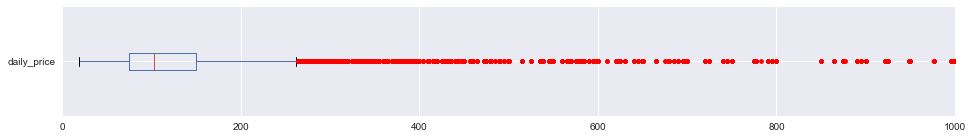

In [16]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['daily_price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [17]:
df.drop(df[ (df.daily_price > 500) | (df.daily_price == 0) ].index, axis=0, inplace=True)

In [18]:
df['daily_price'].describe()

count    708627.000000
mean        123.749952
std          75.942083
min          19.000000
25%          75.000000
50%         100.000000
75%         149.000000
max         500.000000
Name: daily_price, dtype: float64

In [19]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df.shape))

The dataset has 708627 rows and 58 columns - after being price-wise preprocessed.


In [20]:
df.isna().sum()

price_id                           0
daily_price                        0
weekly_price                  463091
cleaning_fee                       0
security_deposit                   0
availability_id                    0
availability_30                    0
availability_60                    0
availability_90                    0
amenity_id                         0
wireless_Internet                  0
air_conditioning                   0
pool                               0
self_check_in                      0
private_entrance                   0
breakfast                          0
free_parking_on_premises           0
tv                                 0
gym                                0
hot_tub                            0
indoor_fireplace                   0
heating                            0
family_kid_friendly                0
washer                             0
dryer                              0
hangers                            0
iron                               0
s

In [22]:
# drop the columns with nan_values
df.drop(columns=['weekly_price'], inplace=True)

In [ ]:
# !pip install geopy

In [23]:
from geopy.distance import great_circle

In [82]:
def distance_to_mid(latitude, longitude):
    los_angeles_center = (34.0522, 118.2437)
    accommodation = (latitude, longitude)
    return great_circle(los_angeles_center, accommodation).km

In [83]:
df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [105]:
df["cleaning_fee_2"] = df["cleaning_fee"].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
df["security_deposit_2"] = df["security_deposit"].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
df["distance"] = df["distance"].astype(str).str.replace('km', '').str.replace(',', '').astype(float)

In [56]:
# colstocheck = df.columns
# df[colstocheck] = df['distance'].replace({'\km':''}, regex = True)

In [107]:
df.head(20)

,price_id,daily_price,cleaning_fee,security_deposit,availability_id,availability_30,availability_60,availability_90,amenity_id,wireless_Internet,...,minimum_nights,maximum_nights,latitude,longitude,neighbourhood,zipcode,distance,size,cleaning_fee_2,security_deposit_2
0,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
1,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
2,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
3,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
4,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
5,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
6,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
7,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
8,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0
9,3,55.0,0.0,0.0,3,18,43,73,3,1,...,1,1125,34.51013,-118.212407,Acton,93510,10390.172326,32.0,0.0,0.0


In [108]:
# df['cleaning_fee'] = (df['cleaning_fee'].str.strip('$').astype(int))
# clean up the columns (by method chaining)
# df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
# df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
# df.distance = df.distance.str.replace('km', '').str.replace(',', '').astype(float)
df.dtypes

price_id                int64
daily_price           float64
cleaning_fee          float64
security_deposit      float64
availability_id         int64
                       ...   
zipcode                object
distance              float64
size                  float64
cleaning_fee_2        float64
security_deposit_2    float64
Length: 61, dtype: object

In [ ]:
# Location is always an important factor in lodging services.
# To make it more descriptive, I decided to calculate each accommodation's distance to
# the so-called centroid of Berlin instead of just relying on the neighbourhoods or areas.

In [109]:
df[['listing_description', 'size']].head(10)

,listing_description,size
0,My place is close to Six Flags Magic Mountain ...,32.0
1,My place is close to Six Flags Magic Mountain ...,32.0
2,My place is close to Six Flags Magic Mountain ...,32.0
3,My place is close to Six Flags Magic Mountain ...,32.0
4,My place is close to Six Flags Magic Mountain ...,32.0
5,My place is close to Six Flags Magic Mountain ...,32.0
6,My place is close to Six Flags Magic Mountain ...,32.0
7,My place is close to Six Flags Magic Mountain ...,32.0
8,My place is close to Six Flags Magic Mountain ...,32.0
9,My place is close to Six Flags Magic Mountain ...,32.0


In [110]:
# extract numbers 
df['size'] = df['listing_description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df['size'] = df['size'].str.replace("\D", "")

# change datatype of size into float
df['size'] = df['size'].astype(float)

print('NaNs in size_column absolute:     ', df['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df['size'].isna().sum()/len(df),3), '%')

NaNs in size_column absolute:      435201
NaNs in size_column in percentage: 0.614 %


In [111]:
df.listing_description.isna().sum()

124

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708627 entries, 0 to 719334
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   price_id                    708627 non-null  int64  
 1   daily_price                 708627 non-null  float64
 2   cleaning_fee                105489 non-null  float64
 3   security_deposit            280227 non-null  float64
 4   availability_id             708627 non-null  int64  
 5   availability_30             708627 non-null  int64  
 6   availability_60             708627 non-null  int64  
 7   availability_90             708627 non-null  int64  
 8   amenity_id                  708627 non-null  int64  
 9   wireless_Internet           708627 non-null  int64  
 10  air_conditioning            708627 non-null  int64  
 11  pool                        708627 non-null  int64  
 12  self_check_in               708627 non-null  int64  
 13  private_entran

In [118]:
# filter out sub_df to work with
selected_features = df[['accommodates', 'bathrooms', 'bedrooms',  'daily_price', 'cleaning_fee_2', 
                 'security_deposit_2', 'distance_2','size']]

KeyError: "['distance_2'] not in index"

In [114]:
# Read the training data into a dataframe
X = selected_features[['accommodates', 'bathrooms', 'bedrooms',  'daily_price', 'cleaning_fee', 
                 'security_deposit', 'distance','size']]
y = selected_features['daily_price']

In [115]:
X.dtypes

accommodates          int64
bathrooms           float64
bedrooms            float64
daily_price         float64
cleaning_fee        float64
security_deposit    float64
distance            float64
size                float64
dtype: object

In [116]:
# import Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [117]:
# fit model to training data
model.fit(X_train, y_train)

ValueError: could not convert string to float: '$0.00'

In [46]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=0.2)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [38]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [39]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (273426, 8)
Shape of Test Data:     (435201, 8)

Shape of X_train: (273426, 7)
Shape of X_test: (435201, 7)

Shape of y_train: (273426,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

ValueError: could not convert string to float: '$0.00'

In [43]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [ ]:
# making predictions
y_test = linreg.predict(X_test)

In [ ]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

In [ ]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
print(new_test_data.shape)
new_test_data.head()

In [ ]:
new_test_data['size'].isna().sum()

In [ ]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

In [ ]:
sub_df_new['size'].isna().sum()

In [ ]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [ ]:
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

In [ ]:
# prices differences on a map
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

In [ ]:
# price differences by neighbourhood
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

In [ ]:
# boxplots
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

In [ ]:
# convert all string into categorical
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [ ]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

In [ ]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [ ]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [ ]:
print(features_recoded.shape)
features_recoded.head(2)

In [ ]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

In [ ]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [ ]:
#Training XGBoost Regressor
# create a baseline
booster = xgb.XGBRegressor()

In [ ]:
# Some of the important hyperparameters to tune an XGBoost are:

# n_estimators    = Number of trees one wants to build.
# learning_rate   = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
# max_depth   = Determines how deeply each tree is allowed to grow during any boosting round.
# colsample_bytree = Percentage of features used per tree.
# gamma   = Specifies the minimum loss reduction required to make a split.

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

In [ ]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [ ]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

In [ ]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

In [ ]:
# Cross Validation

# In order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the nfolds parameter, which is the number of cross validation rounds you want to build.

# Also, it supports many other parameters:

# num_boost_round    = Specifies the number of trees to build (analogous to n_estimators).
# metrics    = Specifies the evaluation metrics to be checked during CV.
# as_pandas   = Returns the results in a decent pandas DataFrame.
# early_stopping_rounds = Finishes model training early if the hold-out metric does not improve for a given number of rounds.
# We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [ ]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [ ]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [ ]:
cv_results.head()

In [ ]:
cv_results.tail()

In [ ]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');